# Trabajo 1: Preprocesamiento y evaluación de clasificadores 


**Integrantes del grupo:**

- Monya Tayebi Hillali
- Alicia Jiajun Lorenzo Lourido

### ***Librerías utilizadas***

In [1]:
# base 
import math
import pandas as pd
import numpy as np
import os
# 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as mi
#
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
# filtros
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFwe
# wrappers
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV


# resample
from sklearn.utils import resample

# evaluation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold



# Modelos 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Almacenamiento de modelos 
import pickle

# Warnings
import warnings


In [2]:
SEED_VALUE = 28

In [3]:
warnings.simplefilter("ignore")

### ***Carga de datos***

In [4]:
path_data='./data/datos_accidentes_cerebrovasculares.csv'
datos = pd.read_csv(path_data, sep=',')

### **Análisis descriptivo de los datos**

#### ***Información de los datos***

Comenzamos viendo los datos en la tabla ,  el número de filas y columnas de nuestro dataset : 

In [5]:
#datos.shape
datos

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Vemos como tenemos los datos de 5110 pacientes y los valores de 11 parámetros de entrada distintos y 1 de salida. 

Con los siguientes métodos modificamos los datos no numéricos a numericos para poder visualizarlos empleando la librería seaborn. Posteriormente se incidirá más en esta cuestión. A continuación, se muestran las funciones empleadas para realizar dicha conversión, luego se aplica sobre las columnas de tipo de dato no numérico que podemos ver en la salida anterior.

In [7]:
def get_dict_of_relation_value_and_numeric(dataframe,column):
    return {value:number for number,value in enumerate(dataframe[column].unique())}
def transform_data_of_column_to_numeric(dataframe,column):
    dataframe[column] = dataframe[column].map(get_dict_of_relation_value_and_numeric(dataframe,column)) 
def transform_data_to_numeric(dataframe,column_list):
    for column in column_list:
        transform_data_of_column_to_numeric(dataframe, column)

In [8]:
datos_tranform = datos.copy() 
column_list=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status']
transform_data_to_numeric(datos_tranform, column_list)

In [9]:
datos_tranform.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,0,0,0,0,228.69,36.6,0,1
1,51676,1,61.0,0,1,0,1,1,202.21,NaN,1,1
2,31112,0,80.0,0,0,0,0,1,105.92,32.5,1,1
3,60182,1,49.0,0,1,0,0,0,171.23,34.4,2,1
4,1665,1,79.0,1,1,0,1,1,174.12,24.0,1,1


Ahora, representaremos por pares todas las variables del dataset:

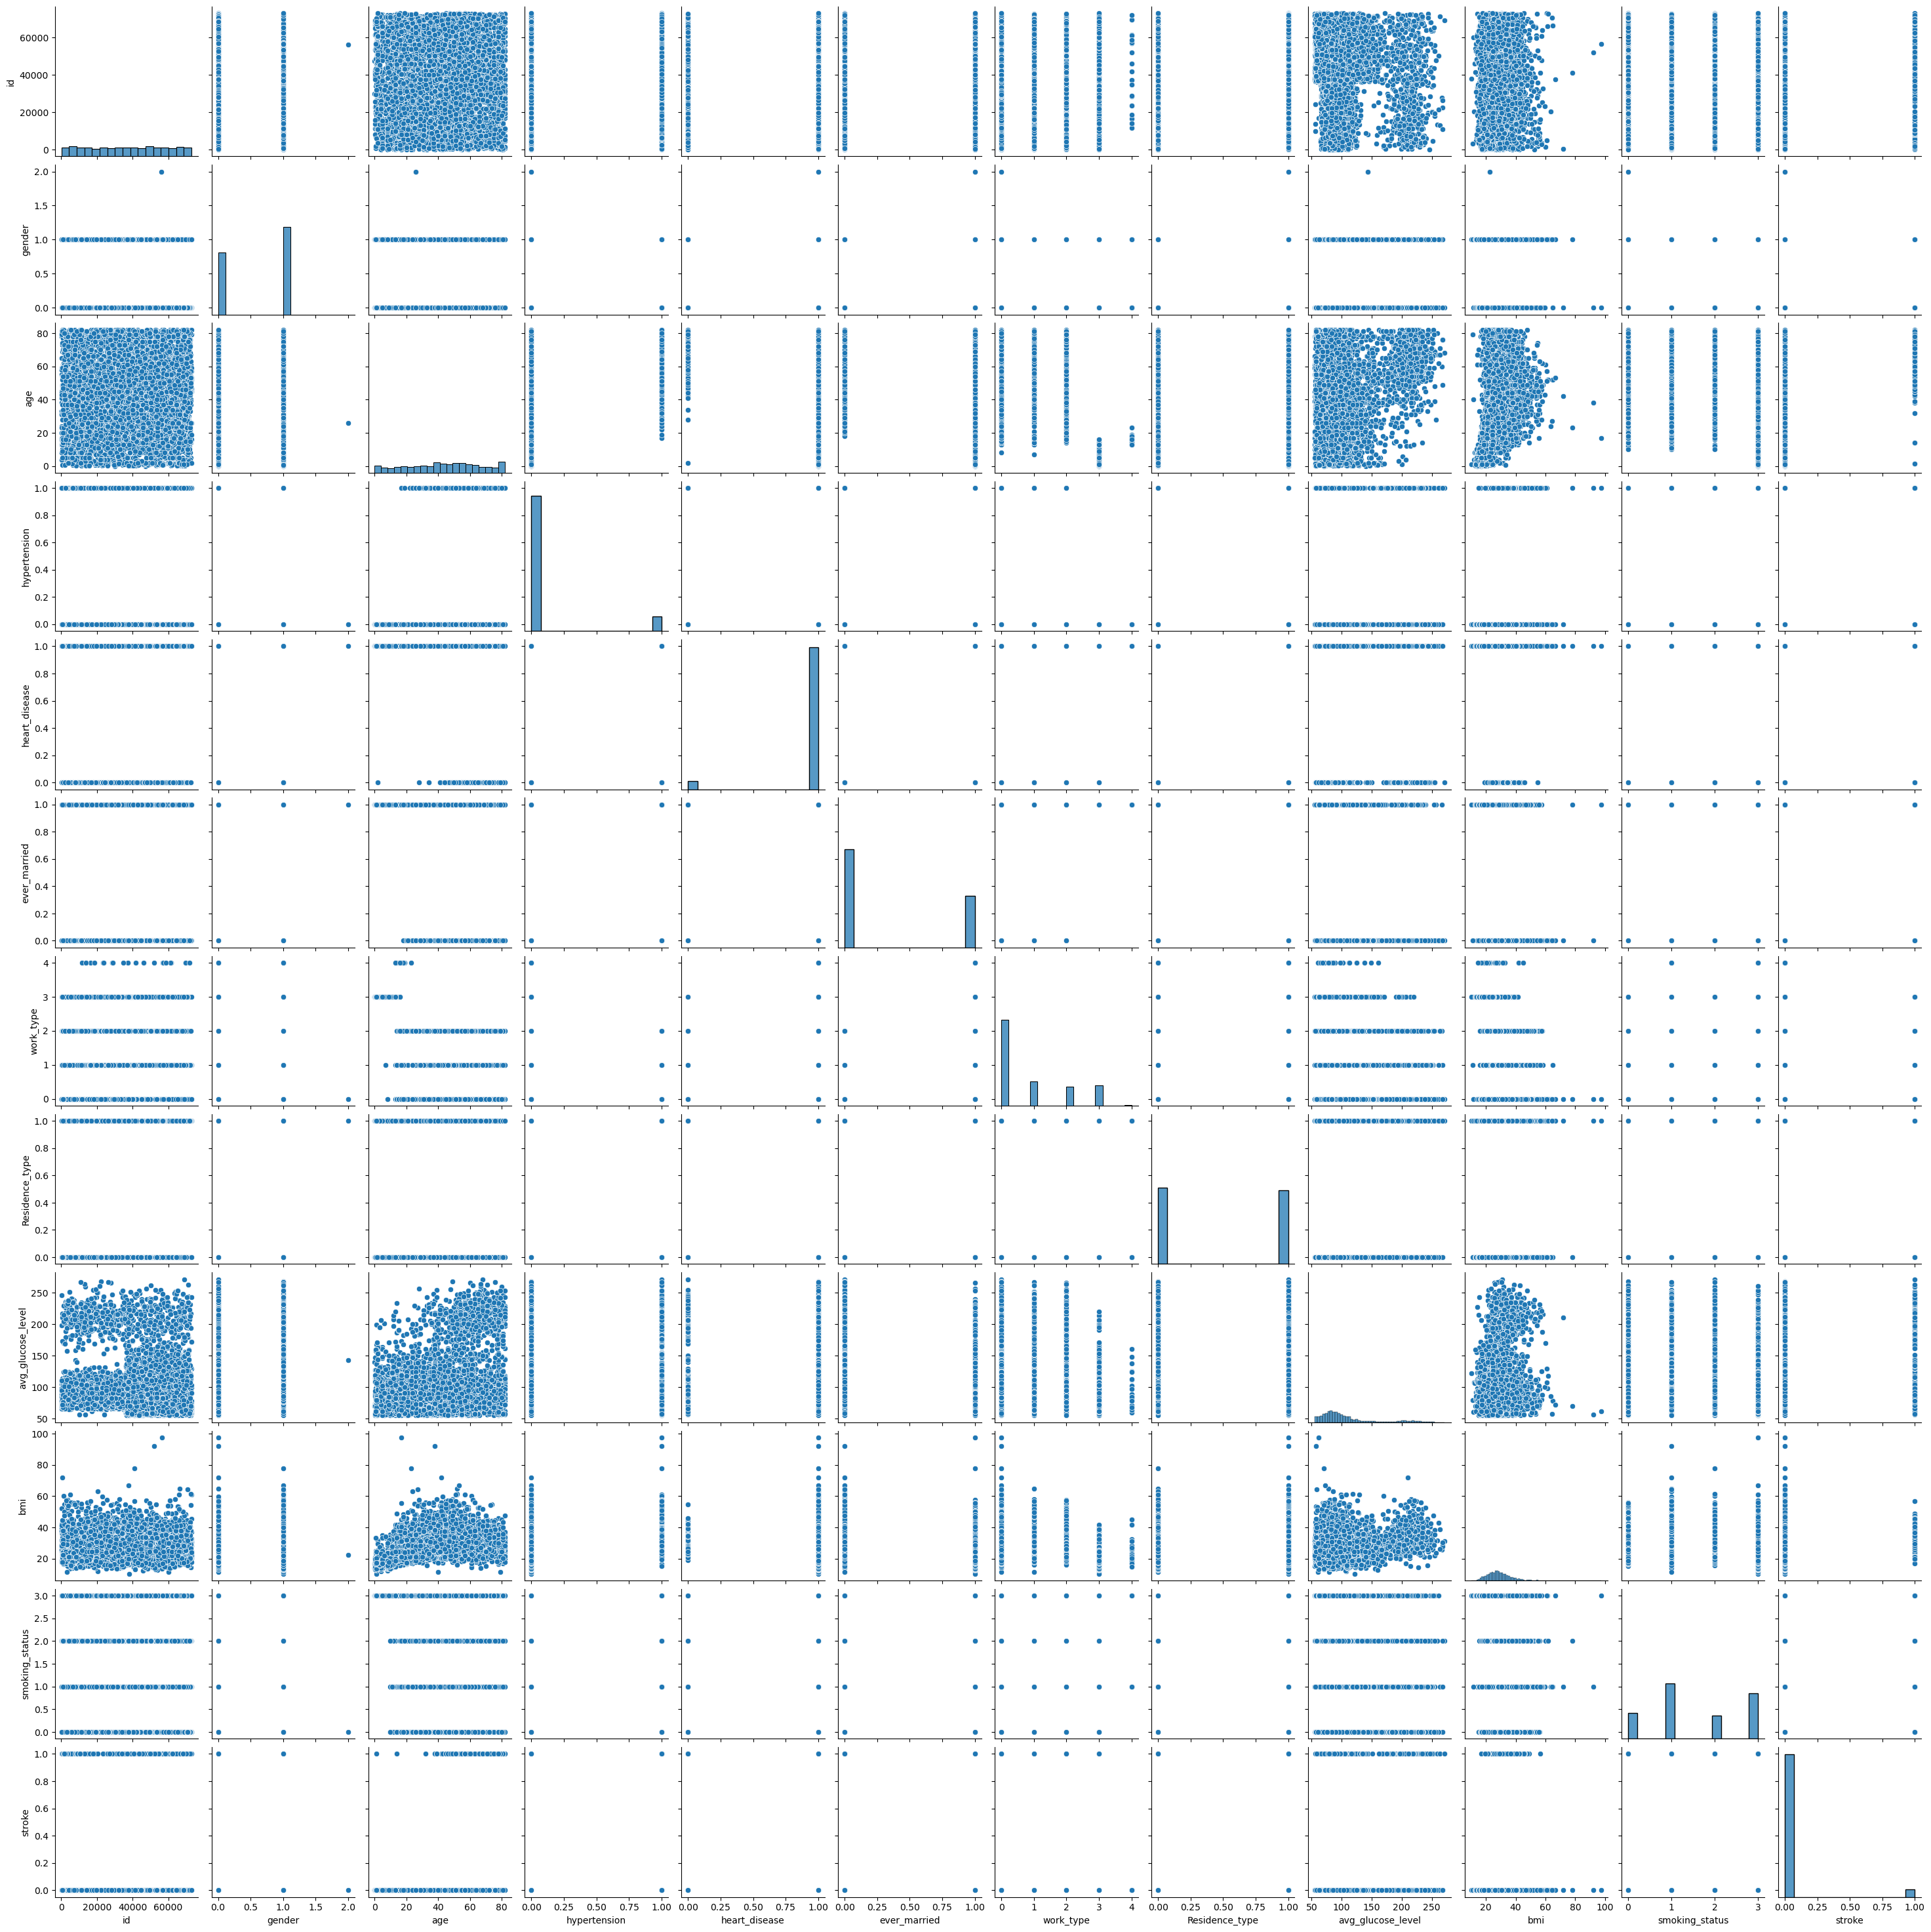

In [10]:
sns.pairplot(datos_tranform)

En este primer gráfico podemos ver como muchos de los sub-gráficos no aportan información clara sobre el conjunto de datos pero sí que podemos destacar la representación de las variables *stroke* y *age* donde vemos que a partir de los 40 años es donde los ataques son más frecuentes así como en el gráfico de los pares de variables *stroke* y *bmi* donde los ataques son más frecuentes para índices de masa corporal entre 20 y 60.

##### ***Información de los atributos***

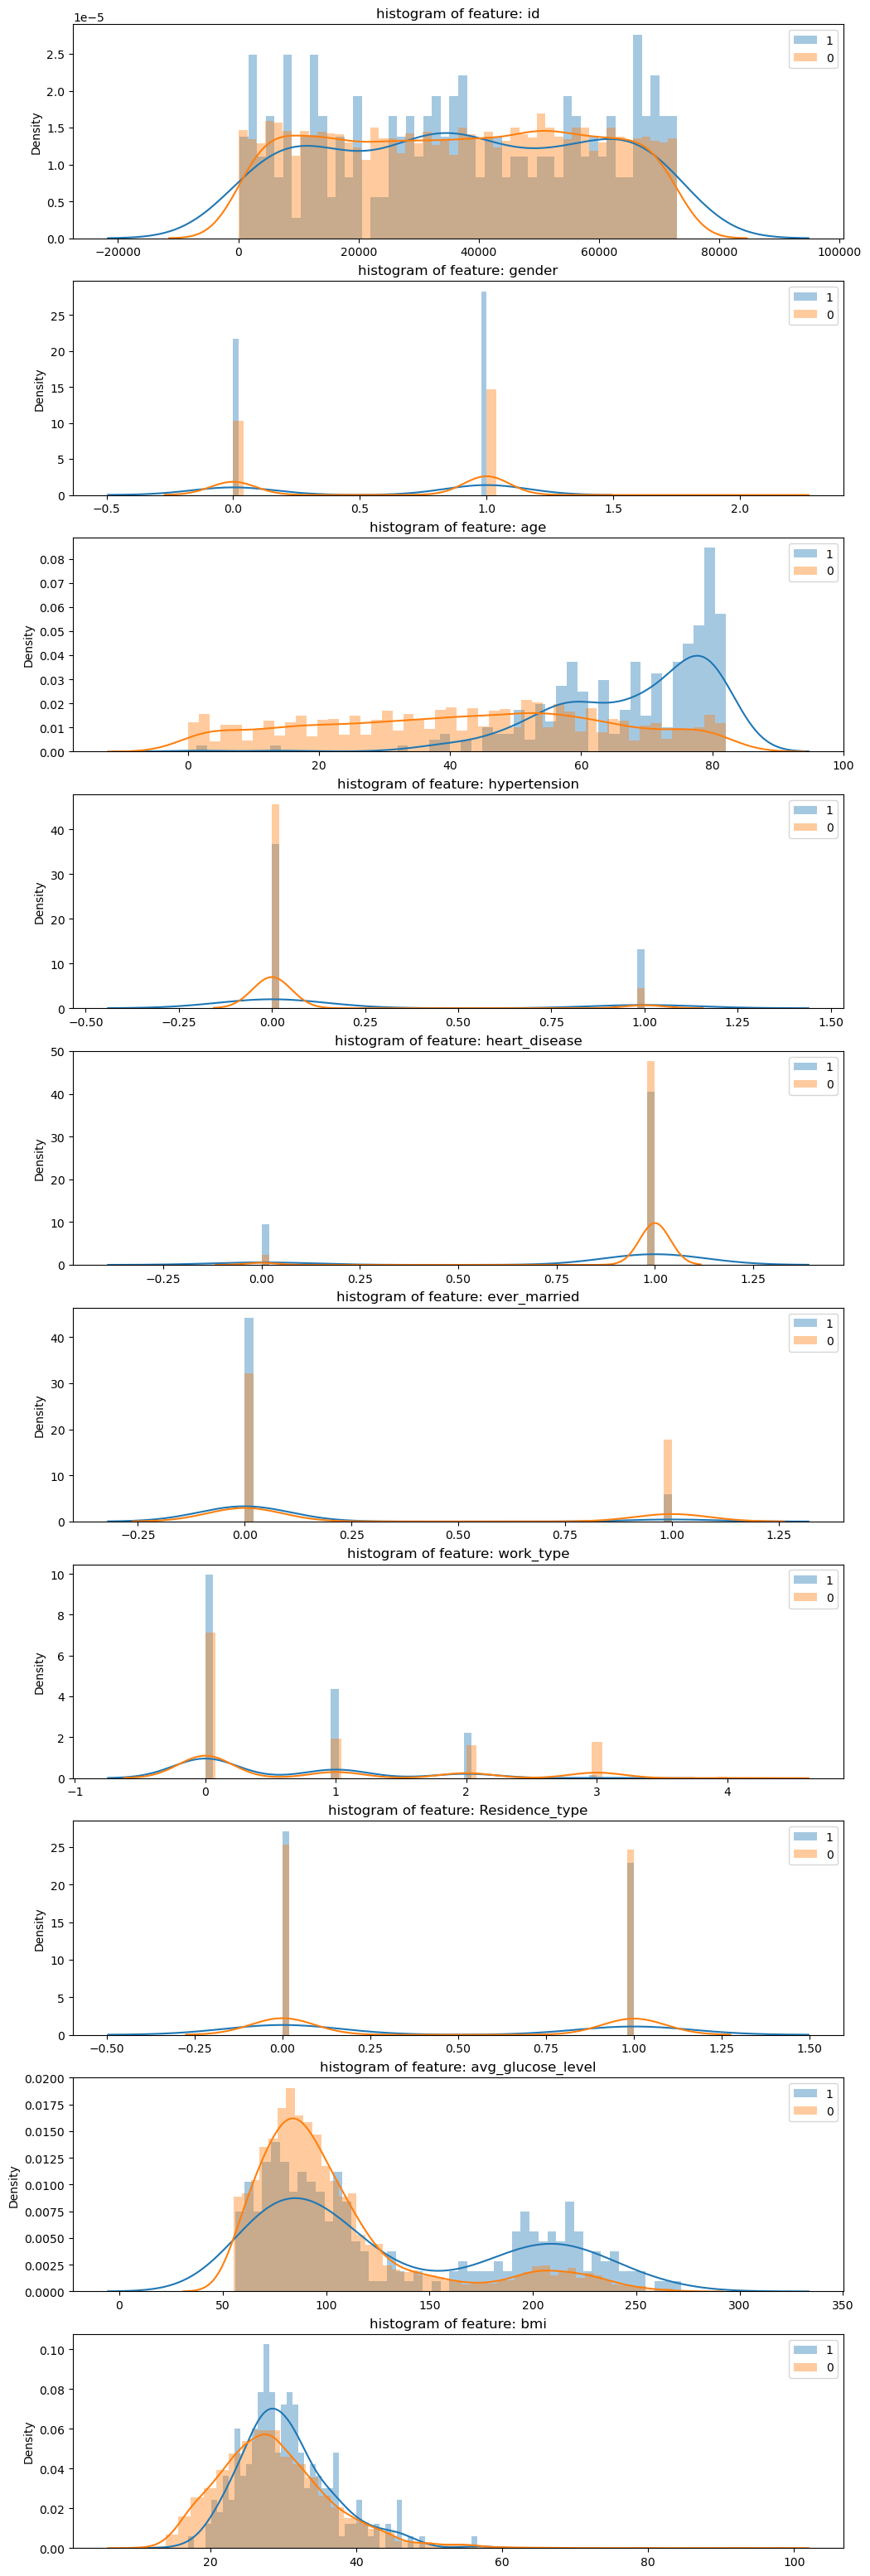

In [11]:
import matplotlib.gridspec as gridspec
columns=datos_tranform.columns[:10]
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datos_tranform[columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(datos_tranform[cn][datos_tranform['stroke'] == 1], bins=50, label='1')
    sns.distplot(datos_tranform[cn][datos_tranform['stroke'] == 0], bins=50, label='0')
    ax.set_xlabel('')
    plt.legend()
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [12]:
def count_unique_values_column(data,column):
    # Verificar si la columna existe en el DataFrame
    if column not in data.columns:
        return "La columna especificada no existe en el DataFrame."
    # Obtener los valores únicos y contar su frecuencia
    unique_values_counts = data[column].value_counts().to_dict()
    return unique_values_counts

def compare_two_columns(data,column_name_1,column_name_2):
    values_uniques_1=data[column_name_1].unique()
    values={}
    for value_unique in values_uniques_1:
        values[value_unique]=count_unique_values_column(data[data[column_name_1]==value_unique],column_name_2)
    return values
def create_dataframe_from_dict(values,column_name_1):
    result_df = pd.DataFrame(values).T.fillna(0).astype(int)
    result_df.index.name = column_name_1
    
    return result_df
def plot_bar_comparative(data,column_name_1,column_name_2='stroke'):
    # Graficar
    data_comparate=compare_two_columns(data,column_name_1,column_name_2)
    print(data_comparate)
    resultado=create_dataframe_from_dict(data_comparate,column_name_1)
    
    resultado.plot(kind='bar')
    plt.title('Comparación de valores de "stroke" por {}'.format(column_name_1))
    plt.xlabel(column_name_1)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=0)
    plt.legend(title='Stroke')
    plt.show()

In [13]:
# Definir función personalizada para pairplot con colores diferenciados por 'stroke'
def custom_pairplot(data, hue):
    sns.set(style="ticks")
    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'})

# Definir función personalizada para pairplot con colores diferenciados por 'stroke' y puntos transparentes
def custom_pairplot_1(data, hue):
    sns.set(style="ticks")
    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'}, plot_kws={'alpha': 0.5})

    
def custom_pairplot_2(data, hue):
    def custom_scatter(x, y, hue, **kwargs):
        plt.scatter(x, y, alpha=0.5 if hue.iloc[0] == 0 else 1, **kwargs)

    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'}, plot_kws={'scatter_kws': {'alpha': 0.5}}, diag_kind='hist', diag_kws={'alpha': 0.5})
    # Sobrescribir la función scatter de seaborn para aplicar alpha condicionalmente
    
def custom_pairplot_3(data, hue):
    def custom_scatter(x, y, hue, **kwargs):
        if hue.iloc[0] == 0:
            kwargs['alpha'] = 0.5
        plt.scatter(x, y, **kwargs)

    sns.pairplot(data, hue=hue, palette={0: 'blue', 1: 'red'})
    # Sobrescribir la función scatter de seaborn para aplicar alpha condicionalmente
    for ax in plt.gcf().get_axes():
        ax.scatter = custom_scatter
    


{'Male': {0: 2007, 1: 108}, 'Female': {0: 2853, 1: 141}, 'Other': {0: 1}}


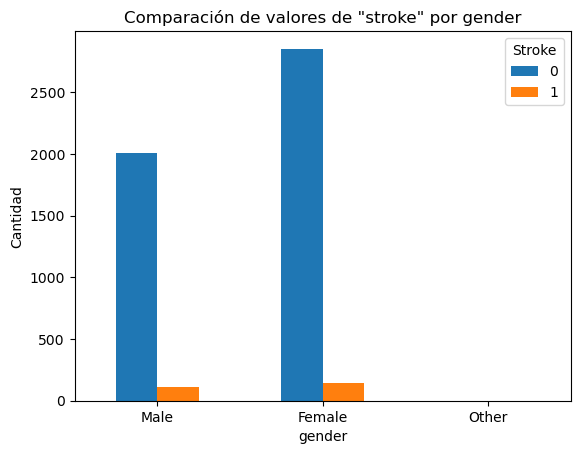

{0: {0: 4429, 1: 183}, 1: {0: 432, 1: 66}}


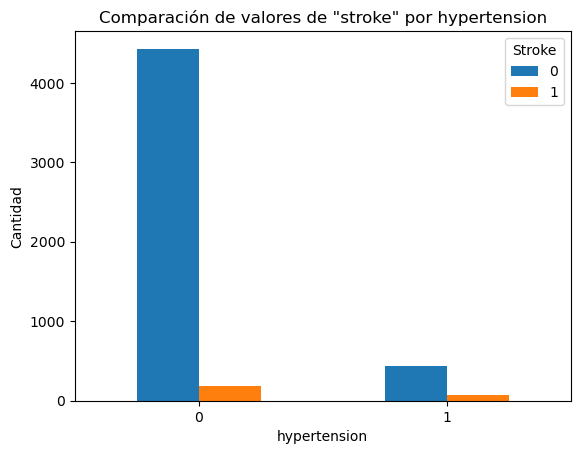

{1: {0: 229, 1: 47}, 0: {0: 4632, 1: 202}}


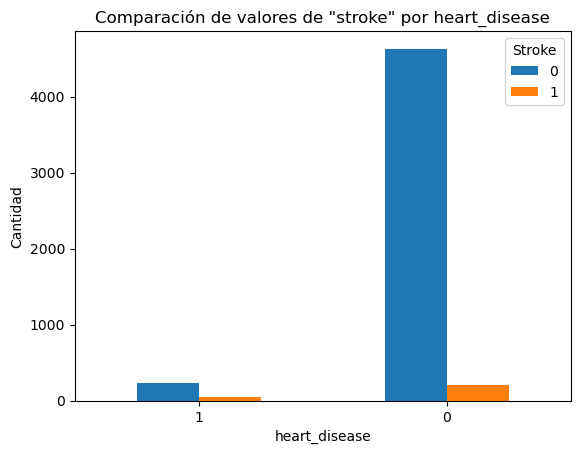

{'Yes': {0: 3133, 1: 220}, 'No': {0: 1728, 1: 29}}


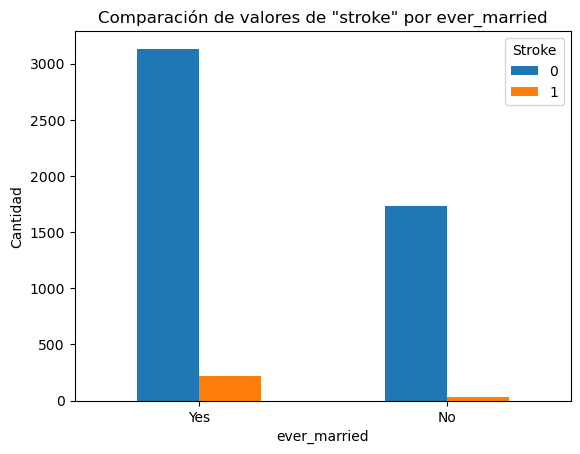

{'Private': {0: 2776, 1: 149}, 'Self-employed': {0: 754, 1: 65}, 'Govt_job': {0: 624, 1: 33}, 'children': {0: 685, 1: 2}, 'Never_worked': {0: 22}}


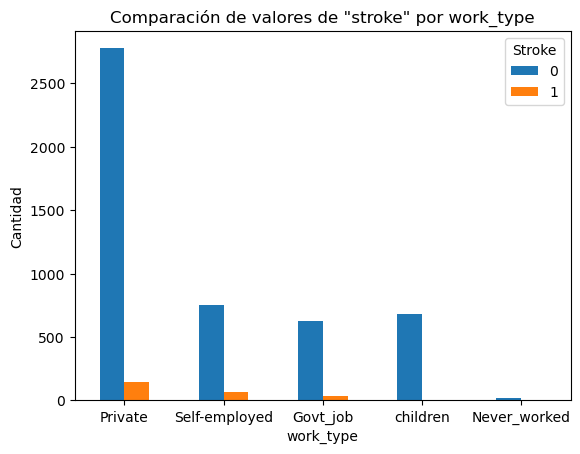

{'Urban': {0: 2461, 1: 135}, 'Rural': {0: 2400, 1: 114}}


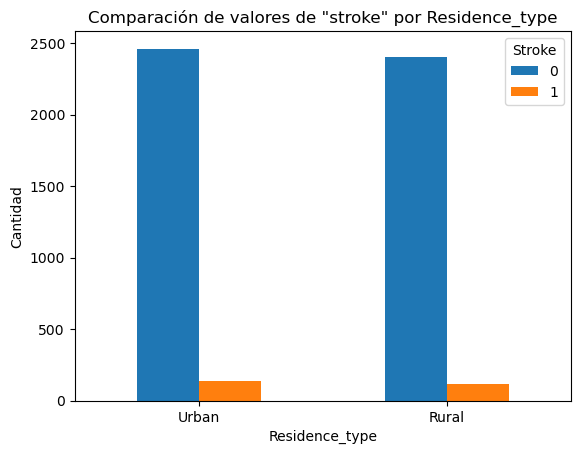

{'formerly smoked': {0: 815, 1: 70}, 'never smoked': {0: 1802, 1: 90}, 'smokes': {0: 747, 1: 42}, 'Unknown': {0: 1497, 1: 47}}


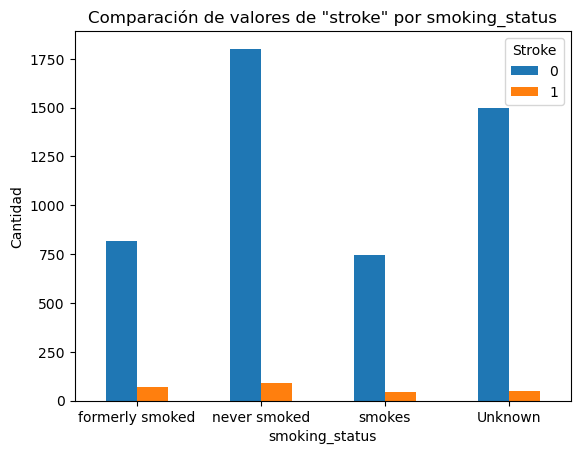

In [14]:
for column in datos.columns:
    if len(datos[column].unique())<10 and column!='stroke':
        plot_bar_comparative(datos,column)

<Figure size 1200x600 with 0 Axes>

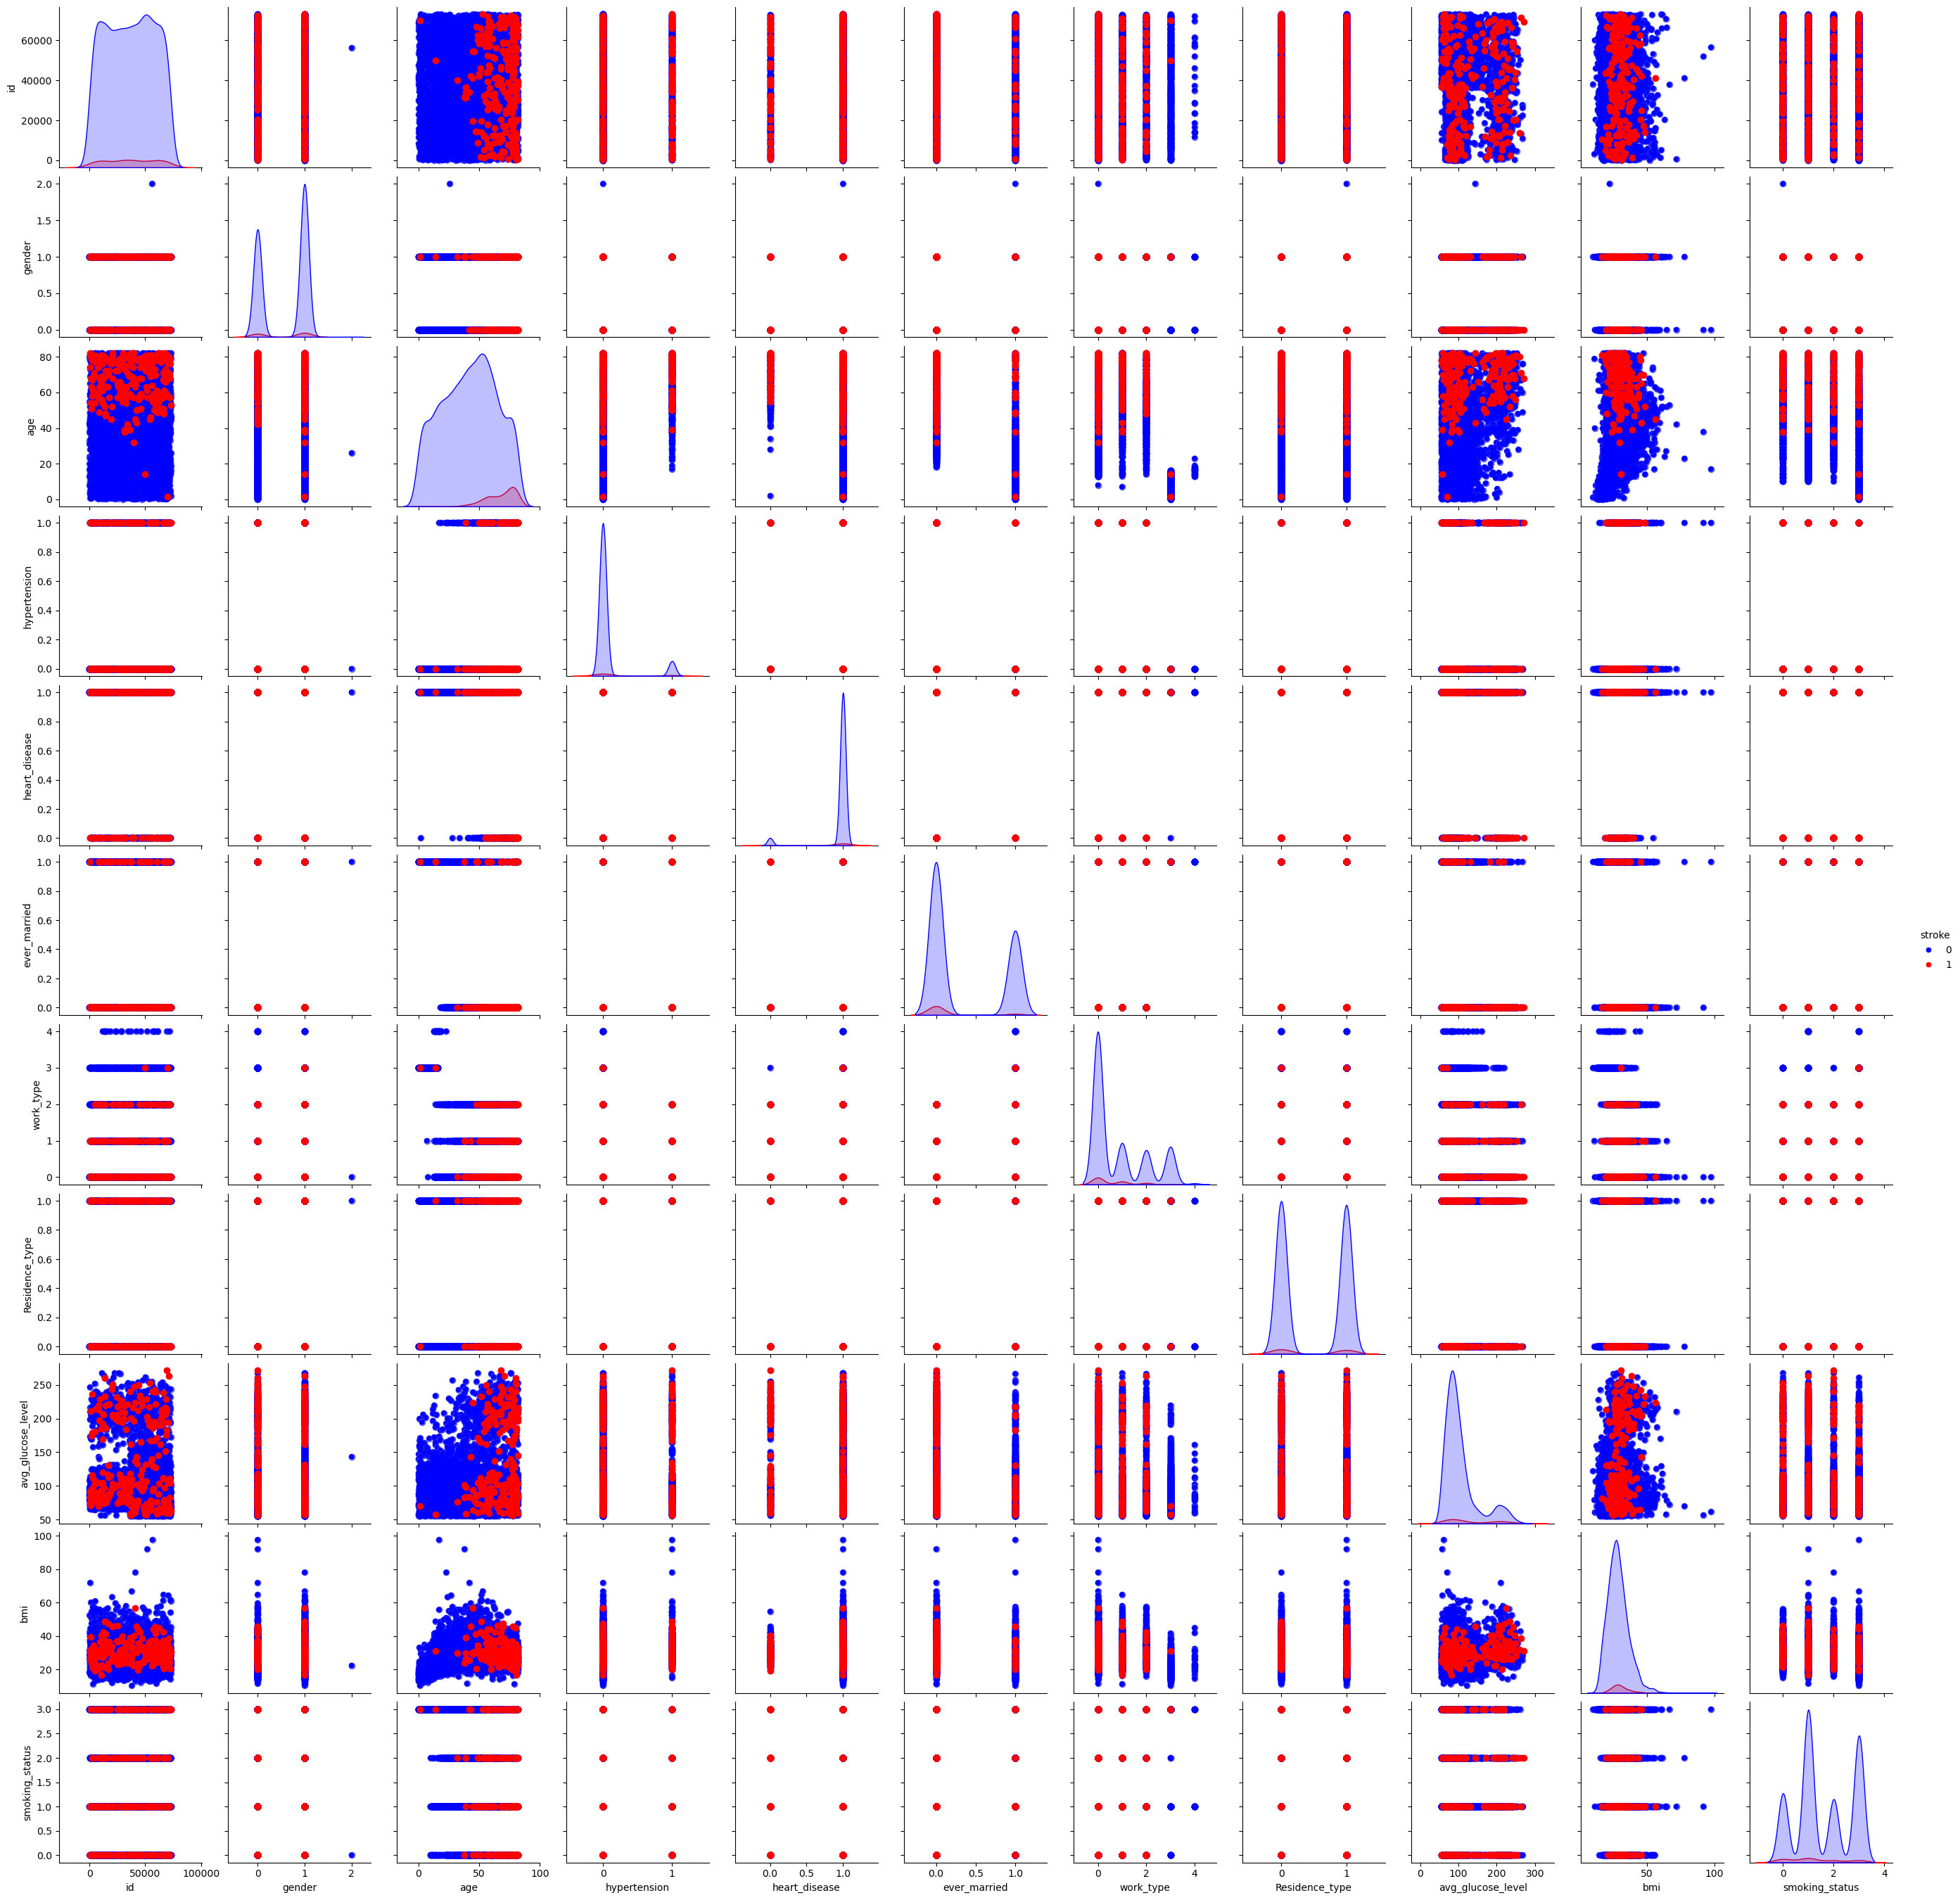

In [15]:
# Graficar
plt.figure(figsize=(12, 6))
# Filtrar datos donde 'stroke' es igual a 0
df_stroke_0 = datos_tranform[datos_tranform['stroke'] == 0]

# Crear pairplot
g = sns.pairplot(data=datos_tranform, hue='stroke', palette={0: 'blue', 1: 'red'})

# Superponer puntos donde 'stroke' es igual a 1 sobre el pairplot
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if i != j:
            g.axes[i, j].scatter(df_stroke_0.iloc[:, j], df_stroke_0.iloc[:, i], c='blue', alpha=0.5, label='Stroke 0')
            g.axes[i, j].scatter(datos_tranform[datos_tranform['stroke'] == 1].iloc[:, j], datos_tranform[datos_tranform['stroke'] == 1].iloc[:, i], c='red', label='Stroke 1')
            #g.axes[i, j].legend()

plt.show()

### ***Preprocesado***

#### ***Gestión de datos ausentes***

En este apartado comprobaremos si hay datos ausentes, y los trataremos.

In [16]:
datos.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Vemos en la salida anterior que hay valores ausentes y se indican como NaN.

In [17]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Si mostramos la información del dataframe vemos que de las 12 columnas del dataset, solo la columna *bmi* tiene datos faltantes, concretamente 201 elementos faltantes. Otra forma de verlo es usando *isnull().sum()*, como sigue, y vemos como efectivamente solo la columna *bmi* tiene datos faltantes: 

In [18]:
datos.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Podemos representarlo en forma matricial, donde cada fila representa uno de los objetos, y los valores ausentes se representan en blanco, y vemos como se distribuyen los valores ausentes en la columna *bmi*:

<Axes: >

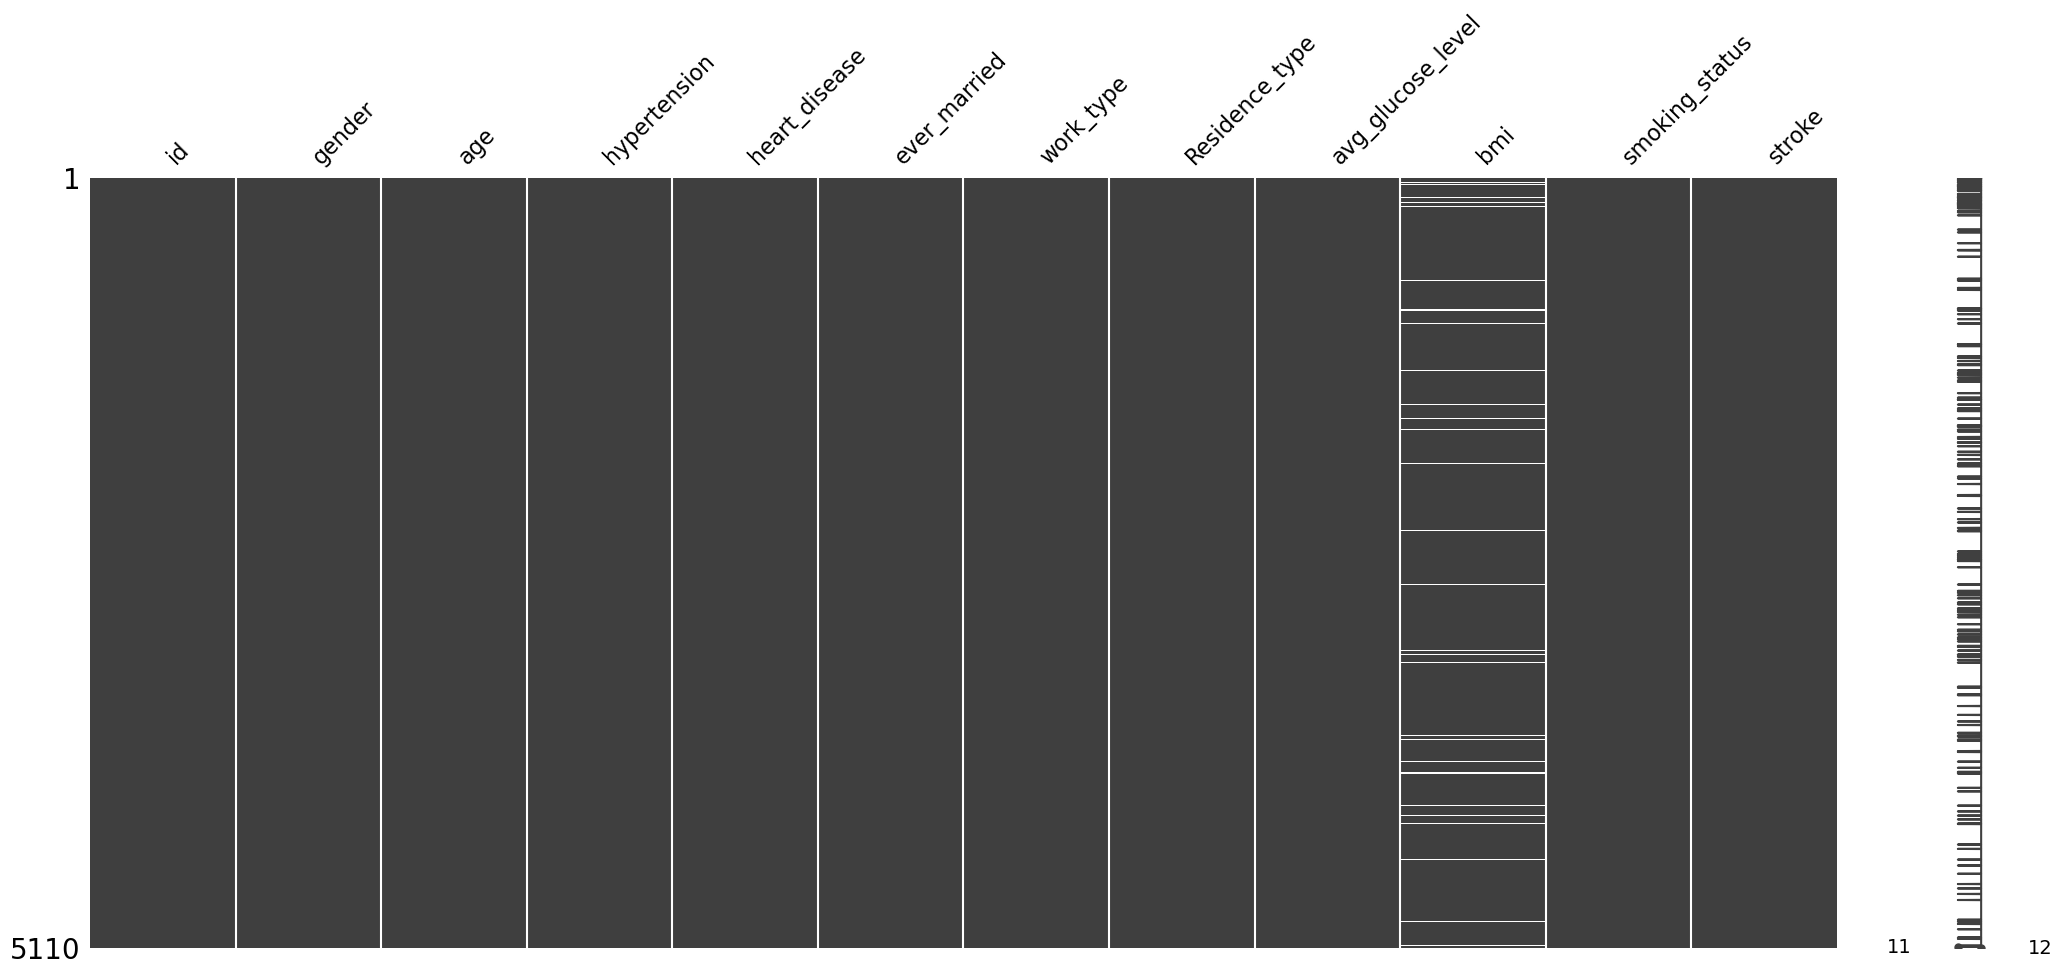

In [19]:
mi.matrix(datos)

A continuación, daremos solución a estos datos ausentes. Como hemos visto, son 201 objetos con el dato de *bmi* faltante sobre un total de 5110, es decir, un 4% aproximadamente de los objetos carecen de valor para este atributo. Al tratarse de un porcentaje bajo podríamos optar por eliminar los objetos pero no lo haremos así, optaremos por su imputación.  

Seguidamente, al tratarse de una variable con datos reales, emplearemos las siguientes estrategias de imputación: media, mediana, valor más frecuente, constante y KNN. 

In [20]:
def imputar_datos(datos, estrategia='mean', fill_value=None, **kwargs):
    """
    Imputa los valores faltantes en un dataframe utilizando diferentes estrategias.

    Parámetros:
    - datos: DataFrame. El dataframe de entrada.
    - estrategia: str. La estrategia de imputación a utilizar ('mean', 'median', 'most_frequent', 'constant', 'knn').
    - fill_value: float o None. El valor de relleno para la estrategia 'constant'.
    - **kwargs: Parámetros adicionales para KNNImputer.

    Retorna:
    - DataFrame. El dataframe con los valores imputados.
    """

    if estrategia == 'knn':
        knni = KNNImputer(**kwargs)
        datos_imputados = datos.copy()
        datos_imputados['bmi'] = knni.fit_transform(datos_imputados['bmi'].values.reshape(-1,1))
    else:
        si = SimpleImputer(strategy=estrategia, fill_value=fill_value)
        datos_imputados = datos.copy()
        datos_imputados['bmi'] = si.fit_transform(datos_imputados['bmi'].values.reshape(-1,1))

    return datos_imputados


def imputar_datos_of_column(datos, estrategias={'mean': None}, **kwargs):
    """
    Imputa los valores faltantes en un dataframe utilizando diferentes estrategias.

    Parámetros:
    - datos: DataFrame. El dataframe de entrada.
    - estrategias: dict. Un diccionario donde las claves son las estrategias de imputación y los valores son los valores de relleno (para la estrategia 'constant') o None.
    - **kwargs: Parámetros adicionales para KNNImputer.

    Retorna:
    - dict. Un diccionario donde las claves son las estrategias de imputación y los valores son los dataframes con los valores imputados.
    """

    datos_imputados = {}

    for estrategia, fill_value in estrategias.items():
           datos_imputados[estrategia]=imputar_datos(datos, estrategia='mean', fill_value=fill_value)
    return datos_imputados


Ahora, procedemos a realizar la imputación de los datos faltantes:

In [21]:
estrategias = {
    'mean': None,
    'median': None,
    'most_frequent': None,
    'constant': 30,
    'knn': {'n_neighbors': 5, 'weights': 'uniform'}
}
datos_imputados_all = imputar_datos_of_column(datos, estrategias=estrategias)

In [22]:
def graficar_imputacion(datos_imputados, null_values):
    """
    Genera gráficos de dispersión con la imputación de datos para cada estrategia.

    Parámetros:
    - datos_imputados: dict. Un diccionario donde las claves son las estrategias de imputación y los valores son los dataframes con los valores imputados.
    - estrategias: list. Una lista de las estrategias de imputación.
    - null_values: Series. Una serie de valores booleanos indicando los valores nulos en los datos originales.

    Retorna:
    - None.
    """

    for estrategia in datos_imputados.keys():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(datos_imputados[estrategia]["age"], datos_imputados[estrategia]["bmi"], c=null_values, cmap='winter')
        ax.set_title(estrategia + ' Imputation')
        plt.colorbar(ax.scatter(datos_imputados[estrategia]["age"], datos_imputados[estrategia]["bmi"], c=null_values, cmap='winter'))
        plt.show()

Una vez realizada la imputación, comparemos gráficamente los diferentes métodos de imputación mediante los siguientes gráficos de dispersion: 

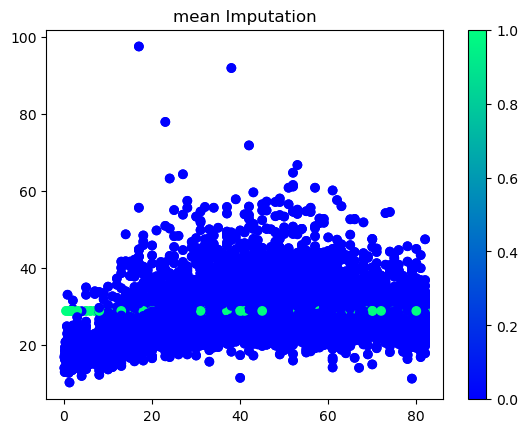

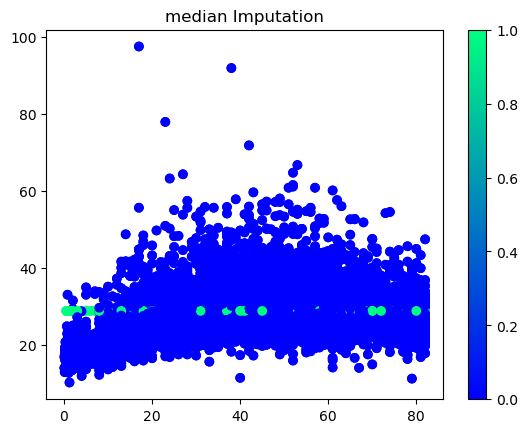

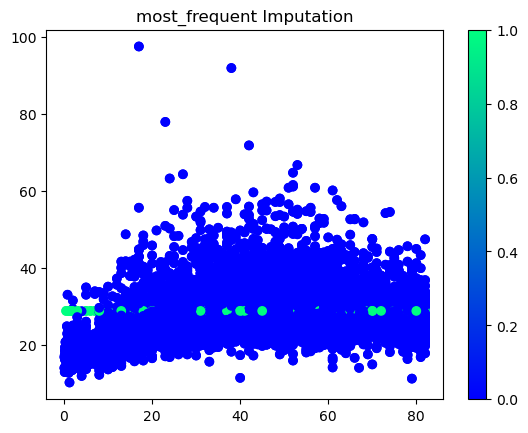

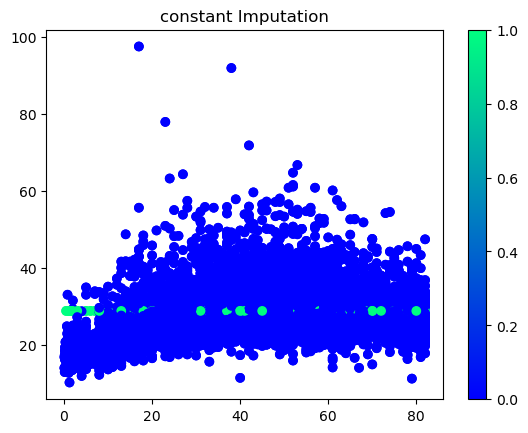

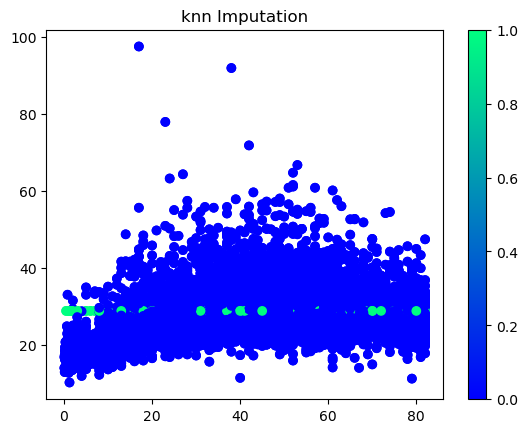

In [23]:
null_values = datos['bmi'].isnull()

graficar_imputacion(datos_imputados_all, null_values)

Finalmente, vemos como en las gráficas anteriores no existe ninguna diferencia notoria por lo que se seleccionará una de las estrategias posteriormente para continuar con el resto de los apartados. 

In [24]:
datos_imputados = datos_imputados_all['mean']

#### ***Transformación de datos***

El objetivo de la presente sección es el de hacer los cambios en los datos que nos permitan continuar con el resto de los apartados. Vemos a continuación como en el dataframe hay atributos que son de tipo de dato int64, otros float64 miemtras que el resto son de tipo object:

In [25]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Como hemos visto anteriormente, los datos de tipo object son datos de tipo texto pero ya que los métodos que aplicaremos posteriormente, en ocasiones no soportan datos de tipo texto, procederemos a realizar una codificación one-hot para estos casos. Por lo tanto, también cambiaremos el tipo de dato de dichas columnas de object a int64. 

Asimismo, debemos transformar la variable de salida *stroke* para que pase de ser de tipo de dato *int64* a *category* ya que usaremos posteriormente modelos de clasificación. Además, en lugar de utilizar el 0 y el 1 como representaciones de las dos clases existentes, los sustimos por 'No' y 'Yes', respectivamente. También, para ser más correctos, las variables donde los posibles valores son 0 o 1 las transformaremos a booleanas. 

In [26]:
# Función para cambiar la representación de la variable de salida
def tranform_column_stroke(datos):
    datos['stroke'].mask(datos['stroke'] == 0, 'No', inplace=True)
    datos['stroke'].mask(datos['stroke'] == 1, 'Yes', inplace=True)

# Función para cambiar el tipo de dato de cada columna al adecuado
def transform_column_type(datos):
    datos['gender'] = datos['gender'].astype('int64')
    datos['hypertension'] = datos['hypertension'].astype('boolean')
    datos['heart_disease'] = datos['heart_disease'].astype('boolean')
    datos['ever_married'] = datos['ever_married'].astype('boolean')
    datos['work_type'] = datos['work_type'].astype('int64')
    datos['Residence_type'] = datos['Residence_type'].astype('int64')
    datos['smoking_status'] = datos['smoking_status'].astype('int64')
    datos['stroke'] = datos['stroke'].astype('category')

# Función para aplicar las transformaciones al dataframe de cada estrategia de imputación
def transform_all_data(datos, column_list=[]):
    tranform_column_stroke(datos)
    transform_data_to_numeric(datos, column_list)
    transform_column_type(datos)
    return datos

Ahora, aplicamos las transformaciones a los datos:

In [27]:
column_list=['gender','ever_married','work_type','Residence_type','smoking_status']
datos_transform = transform_all_data(datos_imputados, column_list=column_list)

In [28]:
datos_transform.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,False,True,False,0,0,228.69,36.600000,0,Yes
1,51676,1,61.0,False,False,False,1,1,202.21,28.893237,1,Yes
2,31112,0,80.0,False,True,False,0,1,105.92,32.500000,1,Yes
3,60182,1,49.0,False,False,False,0,0,171.23,34.400000,2,Yes
4,1665,1,79.0,True,False,False,1,1,174.12,24.000000,1,Yes


Comprobamos a continuación los nuevos tipos de datos de las columnas: 

In [29]:
datos_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   int64   
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   boolean 
 4   heart_disease      5110 non-null   boolean 
 5   ever_married       5110 non-null   boolean 
 6   work_type          5110 non-null   int64   
 7   Residence_type     5110 non-null   int64   
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                5110 non-null   float64 
 10  smoking_status     5110 non-null   int64   
 11  stroke             5110 non-null   category
dtypes: boolean(3), category(1), float64(3), int64(5)
memory usage: 354.6 KB


#### ***Estandarización de datos***

Lo haremos DESPUÉS de dividir los datos en entrenamiento y test en el apartado de modelado. Optamos por estandarización y no por normalización ya que nos aportará mayores beneficios en nuestros modelos...

En este apartado, comenzaremos dando solución al desbalanceo de las clases del dataset que hemos visto en secciones anteriores. Seguidamente, dividiremos los datos en entrenamiento y en test para aplicar la estandarización sobre los datos de entrenamiento porque al tratarse de un problema de clasificación, la variable de salida no tiene sentido estandarizarla. Optamos por estandarización y no por normalización ya que nos aportará mayores beneficios en nuestros modelos...

Comenzamos entonces viendo de nuevo el desbalanceo de nuestro dataset:



stroke
No     4861
Yes     249
Name: count, dtype: int64


<Axes: xlabel='stroke'>

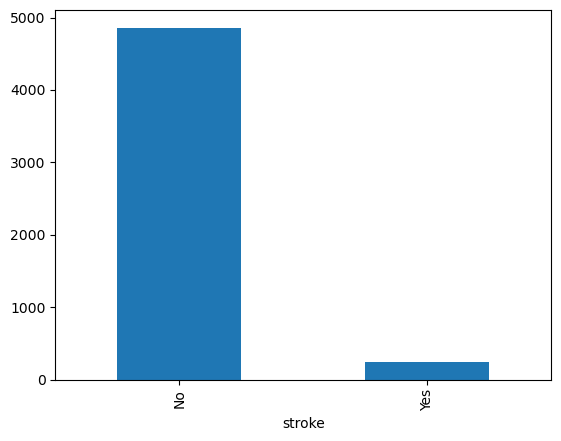

In [30]:
print(datos_transform['stroke'].value_counts())
datos_transform['stroke'].value_counts().plot(kind='bar')

Vemos que aproximadamente el 95% de los datos son de la clase 'No' o 0, es decir, la mayoría de los pacientes no han tenido ningún ataque. Para este caso se optará por el uso de down sampling.


In [64]:
def resample_data(datos, column,fill_value=[]):
    datos1 = datos[datos[column] == fill_value[0]]
    datos2  = datos[datos[column] == fill_value[1]]

    datos3 = resample(datos2, replace=True, n_samples=len(datos1), random_state=SEED_VALUE)

    data_resampled = pd.concat([datos3, datos1])
    return data_resampled

def resample_data_data(datos, column, fill_value=[],key='a',column_y='stroke'):
    datos=datos[key].copy()
    traindata=pd.concat([datos['X_train'],datos['y_train']], axis=1)
    data_resample=resample_data(traindata, column, fill_value=fill_value)
    X = data_resample.drop(column_y, axis=1)
    y = data_resample[column_y]
    datos['X_train']=X
    datos['y_train']=y
    return datos
    

def resample_data_of_column(datos, column='stroke', estrategias = {'downsample': 0, 'upsample': -1}, in_dict=False):
    """
    Balancea las clases en el conjunto de datos usando dos estrategias 

    Parámetros:
    - datos: DataFrame. El dataframe de entrada.
    - estrategias: dict. Un diccionario donde las claves son las estrategias de balanceo de clases
    - **kwargs: Parámetros adicionales.

    Retorna:
    - dict. Un diccionario donde las claves son las estrategias de balanceo y los valores son los dataframes balanceados.
    """

    datos_estandarice = {}

    for estrategia, fill_value in estrategias.items():
        if in_dict:
            datos_estandarice[estrategia] = resample_data_data(datos.copy(), column, fill_value=fill_value)
        else:
            
            datos_estandarice[estrategia] = resample_data(datos.copy(), column, fill_value=fill_value)
        
    return datos_estandarice



In [65]:
estrategias_sample = {
    'downsample': ['Yes','No'],
    'upsample': ['No','Yes'],
}

datos_resampled = resample_data_of_column(datos_transform, column='stroke', estrategias = estrategias_sample)

(498, 12)


<Axes: xlabel='stroke'>

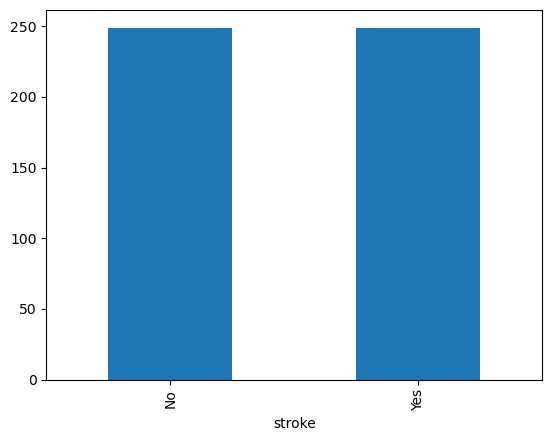

In [66]:
print(datos_resampled['downsample'].shape)
datos_resampled['downsample']['stroke'].value_counts().plot(kind='bar')

(9722, 12)


<Axes: xlabel='stroke'>

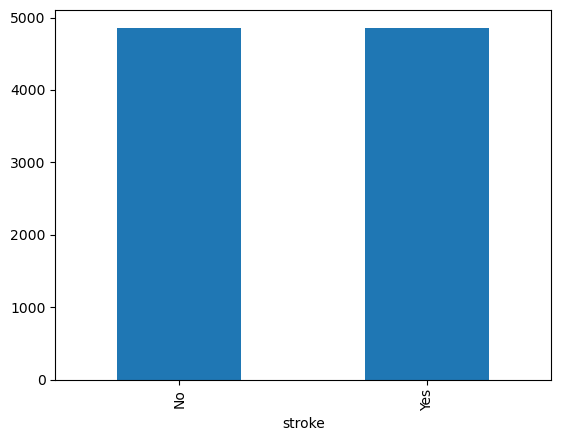

In [67]:
print(datos_resampled['upsample'].shape)
datos_resampled['upsample']['stroke'].value_counts().plot(kind='bar')

In [68]:
def standardize_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def split_data(data, column_y='stroke', test_size=0.2, random_state=SEED_VALUE):
    X = data.drop(column_y, axis=1)
    y = data[column_y]
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def standardize_train_test_split(train_data, test_data):
    columns_to_scale = train_data.select_dtypes(include=['float64']).columns
    X_train_scaled, X_test_scaled = standardize_data(train_data[columns_to_scale], test_data[columns_to_scale])
    train_data[columns_to_scale] = X_train_scaled
    test_data[columns_to_scale] = X_test_scaled
    return train_data, test_data

def standardize_all_strategies(data, column_y='stroke', test_size=0.2, random_state=SEED_VALUE):
    standardized_data = {}
    for strategy, dataset in data.items():
        X_train, X_test, y_train, y_test = split_data(dataset, column_y=column_y, test_size=test_size, random_state=random_state)
        X_train_standardized, X_test_standardized = standardize_train_test_split(X_train, X_test)
        standardized_data[strategy] = {
            'X_train': X_train_standardized,
            'y_train': y_train,
            'X_test': X_test_standardized,
            'y_test': y_test
        }
    return standardized_data

In [69]:
data_to_standarice={'a':datos_transform}

In [70]:
data_standarized = standardize_all_strategies(data_to_standarice.copy())

In [71]:
data_standarized = resample_data_of_column(data_standarized, column='stroke', estrategias = estrategias_sample,
                                           in_dict=True)

In [74]:
data_standarized['downsample']['X_train']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4804,9565,1,-0.184541,False,False,True,0,1,-0.599362,0.135845,1
1204,41565,1,-0.450971,False,False,True,0,0,0.329948,-0.895431,1
2496,8646,1,0.481534,False,False,False,0,1,-0.192527,-0.294941,1
890,72310,0,1.636063,True,True,False,1,0,-0.482400,0.175007,2
5042,40220,0,-0.495376,False,False,True,0,1,-0.122482,-0.360212,0
...,...,...,...,...,...,...,...,...,...,...,...
68,6118,0,0.703559,False,False,False,0,0,-0.440109,0.135845,0
102,45277,1,1.369634,False,False,False,0,1,2.762147,0.736334,0
104,33175,1,0.614749,False,False,False,2,0,0.094922,-0.059967,3
187,67895,1,1.724873,True,True,False,2,0,2.416987,-0.138292,0


<Axes: xlabel='stroke'>

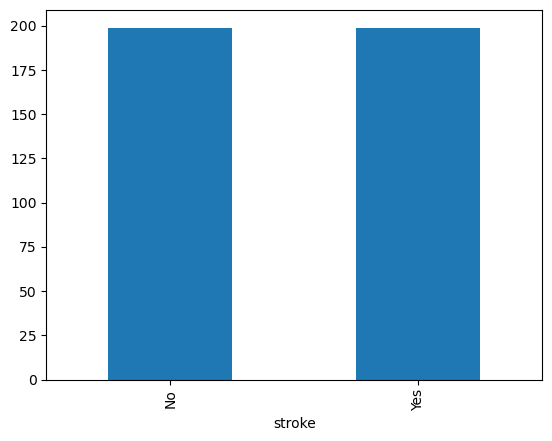

In [82]:
data_standarized['downsample']['y_train'].value_counts().plot(kind='bar')

In [76]:
data_standarized['downsample']['X_test']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4175,5294,1,-1.028236,False,False,False,0,1,-0.296714,-1.156513,3
607,9906,1,-1.836406,False,False,True,3,0,-0.085257,-1.561191,3
1545,52089,1,-0.895021,False,False,True,0,0,0.450655,-0.033859,2
1052,10752,1,0.792369,False,False,False,0,1,-0.607072,0.945200,0
3406,5074,0,-0.850616,False,False,True,0,1,2.068963,1.141012,2
...,...,...,...,...,...,...,...,...,...,...,...
3312,68965,0,-0.006921,False,False,False,0,0,-0.746281,0.945200,2
126,3352,0,1.547253,True,False,False,1,0,-0.288124,-0.008633,0
748,60810,0,0.126294,False,False,False,1,0,-1.109723,-0.334103,1
3930,38613,1,0.303914,False,False,False,2,1,-0.971174,0.083628,1


<Axes: xlabel='stroke'>

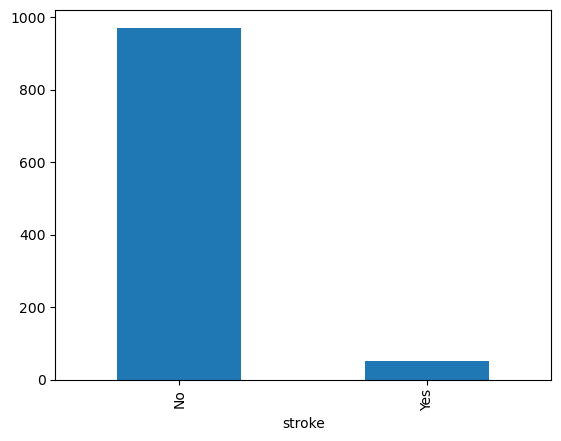

In [81]:
data_standarized['downsample']['y_test'].value_counts().plot(kind='bar')

In [77]:
data_standarized['upsample']['X_train']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
142,8045,1,1.369634,True,False,False,0,0,-0.791436,-0.934593,1
1,51676,1,0.792369,False,False,False,1,1,2.114559,-0.008633,1
169,210,0,1.680468,False,False,False,1,1,-0.323146,0.318603,1
218,25904,1,1.458444,True,True,False,1,0,2.062796,-0.008633,2
13,8213,0,1.547253,False,True,False,0,0,2.502891,-0.008633,3
...,...,...,...,...,...,...,...,...,...,...,...
4644,3595,0,-0.495376,False,False,False,0,0,-0.181955,1.467365,2
565,55424,1,0.925584,True,False,False,0,1,-0.389447,-0.569078,1
3311,37025,1,-1.827525,False,False,True,3,0,0.172016,-1.417596,3
604,33552,0,-0.539781,False,False,False,0,1,0.178624,-0.164400,2


In [ ]:
data_standarized['upsample']['y_train'].value_counts().plot(kind='bar')

In [78]:
data_standarized['upsample']['X_test']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
4175,5294,1,-1.028236,False,False,False,0,1,-0.296714,-1.156513,3
607,9906,1,-1.836406,False,False,True,3,0,-0.085257,-1.561191,3
1545,52089,1,-0.895021,False,False,True,0,0,0.450655,-0.033859,2
1052,10752,1,0.792369,False,False,False,0,1,-0.607072,0.945200,0
3406,5074,0,-0.850616,False,False,True,0,1,2.068963,1.141012,2
...,...,...,...,...,...,...,...,...,...,...,...
3312,68965,0,-0.006921,False,False,False,0,0,-0.746281,0.945200,2
126,3352,0,1.547253,True,False,False,1,0,-0.288124,-0.008633,0
748,60810,0,0.126294,False,False,False,1,0,-1.109723,-0.334103,1
3930,38613,1,0.303914,False,False,False,2,1,-0.971174,0.083628,1


In [ ]:
data_standarized['upsample']['y_test'].value_counts().plot(kind='bar')

#### ***Selección de variables***

*COMENTAR DE FORMA RESUMIDA LO QUE VIMOS EN EL APARTADO DE INFO DE LOS DATOS*



En primer lugar utilizaremos una codificación one-hot que el modelo de selección de características pueda entender. 

In [ ]:
def feature_selection(X_train, y_train, method, name):
    if name != 'RFE' and name != 'RFECV':
        X_new = method.fit_transform(X_train, y_train)
        mask = method.get_support()
        selected_features = X_train.columns[mask]

        print(f'\n{name}:')
        print(f'Tamaño del conjunto de variables seleccionadas: {X_new.shape}')
        print("Características seleccionadas: ", selected_features.values)
        return selected_features

def feature_selection_plot(X_train,y,methods):
    # Gráficos de las puntuaciones univariadas
    plt.figure(figsize=(10, 6))
    X_indices = np.arange(X_train.shape[-1])
    infinite_value=''
    for name, method in methods.items():
            
         # RFE y RFECV
        if 'RFE' in name:
            svc = SVC(kernel="linear", C=1)
            rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
            rfe.fit(X_train, y)
            ranking_rfe = rfe.ranking_
            plt.bar(X_indices + (len(methods) * 0.15) - 0.2, ranking_rfe, width=0.15, label='RFE')

        elif 'RFECV' in name:
            cv = StratifiedKFold(5)
            svc = SVC(kernel="linear", C=1)
            rfecv = RFECV(estimator=svc, step=1, cv=cv, scoring="accuracy", min_features_to_select=1, n_jobs=-1)
            rfecv.fit(X_train, y)
            ranking_score=rfecv.grid_scores_
            plt.bar(X_indices + ((len(methods) + 1) * 0.15) - 0.2,ranking_score , width=0.15, label='RFECV')
        
        elif name != "VarianceThreshold":
            scores = -np.log10(method.pvalues_)
            scores /= scores[scores != np.inf].max()
            plt.bar(X_indices + (list(methods.keys()).index(name) * 0.2) - 0.05, scores, width=0.2, label=name)
            infinite_value=f' value in {scores}'

    plt.title(f"Puntuación univariada de características \n {infinite_value}")
    plt.xlabel("Número de característica")
    plt.ylabel("Puntuación univariada ($-Log(p_{value})$)")
    plt.legend(loc='upper right')
    plt.show()

def feature_selection_comparison(X_train, y_train,methods):
    
    selected_features = {}
    
    for name, method in methods.items():
       
        selected_features[name] = feature_selection(X_train, y_train, method ,name )
        
    
    # Comprobación de igualdad entre los arrays de características seleccionadas
    #if all(selected_features[key].equals(selected_features["SelectKBest"]) for key in selected_features):
    #    print("\nLos 4 arrays son iguales.")
    #else:
    #    print("\nLos arrays no son iguales.")
    
    feature_selection_plot(X_train,y_train,methods)
    
def feature_selection_all(data,methods):
    #feature_selection=[]
    for strategy, dataset in data.items():
        print(strategy)
        feature_selection_comparison(dataset['X_train'].copy(), dataset['y_train'].copy(), methods)

In [ ]:
methods = {
        "VarianceThreshold": VarianceThreshold(threshold=(.8 * (1 - .8))),
        "SelectKBest": SelectKBest(f_classif, k=10),
        "SelectPercentile": SelectPercentile(f_classif, percentile=60),
        "SelectFpr": SelectFpr(f_classif, alpha=0.05),
        "SelectFwe": SelectFwe(f_classif, alpha=0.05),
    }
    
feature_selection_all(data_standarized,methods)

En este caso se ordena las variables por orden de importancia

In [ ]:
methods = {
        "RFE":None,
    }
    
feature_selection_all(data_standarized, methods)

### ***Modelado***

##### ***Cross-validation***

Antes de dividir nuestros datos en conjuntos de entrenamiento y test, veamos si las clases de nuestro dataset están o no desbalanceadas:

In [ ]:

def eval_model(y_test, y_pred, model_name='Model'):
    """
    Evalúa el modelo e imprime las métricas de rendimiento.
    """
    # Calcula las métricas
    precision = precision_score(y_test, y_pred, pos_label='Yes')
    recall = recall_score(y_test, y_pred, pos_label='Yes')
    f1 = f1_score(y_test, y_pred, pos_label='Yes')
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n{model_name}:\n Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, Accuracy: {accuracy:.3f}\n")
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    #print('La matriz de confusión obtenida por el : \n{}'.format(conf_matrix_rf))
    # Preparar datos para la curva ROC
    y_test_num = y_test.map({'No': 0, 'Yes': 1})
    y_pred_num = np.where(y_pred == 'Yes', 1, 0)
    
    fpr, tpr, _ = roc_curve(y_test_num, y_pred_num)
    roc_auc = auc(fpr, tpr)

    # Dibujar la curva ROC
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
     # Curva ROC
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic')
    ax[0].legend(loc="lower right")

    # Matriz de confusión
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=ax[1], cmap="Blues", cbar=False)
    ax[1].set_xlabel('Predicted labels')
    ax[1].set_ylabel('True labels')
    ax[1].set_title('Confusion Matrix')
    ax[1].xaxis.set_ticklabels(['Negative', 'Positive'])
    ax[1].yaxis.set_ticklabels(['Negative', 'Positive'])
    fig.suptitle('{}'.format(model_name))
    plt.tight_layout()
    plt.show()

    return accuracy

def evaluate_hyperparameters(X_train, y_train, model, hyperparameters, model_name='./models/rf_model_v2.pkl'):
    """
    Evalúa los hiperparámetros utilizando GridSearchCV y guarda el mejor modelo.
    """
    grid_search = GridSearchCV(model, hyperparameters, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)
    np.random.seed(SEED_VALUE)
    grid_search.fit(X_train, y_train)
    
    with open(model_name, 'wb') as file:
        pickle.dump(grid_search, file, protocol=pickle.HIGHEST_PROTOCOL)
    
    return grid_search, model_name

def select_model(model_name, params={}):
    """
    Selecciona y devuelve un modelo basado en el nombre del modelo.
    """
    if model_name == 'random_forest':
        model = RandomForestClassifier(**params)
    elif model_name == 'svm':
        model = SVC(**params)
    elif model_name == 'logistic_regression':
        model = LogisticRegression(**params)
    elif model_name=='knn':
        model=KNeighborsClassifier(**params)
    else:
        raise ValueError("Model name not recognized.")
    return model

def compare_models(name,best_indexes,best_hyperparams, X_train, y_train, X_test, y_test,other=''):
    
    """
    Compara modelos utilizando los mejores hiperparámetros encontrados.
    """
    results = {}
    for index, params in enumerate(best_hyperparams):
        model = select_model(name, params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = eval_model(y_test, y_pred, model_name=f"{name}_{other} with params\n {params}")
        results[best_indexes[index]] = {'y_pred': y_pred, 
                                        'accuracy': accuracy,
                                        'model': model} 
    return results

def compare_model_sets(X_train, y_train, X_test, y_test, models, num_top_models=5, reselect=False,
                       other='',strategy=''):
    
    """
    Evalúa y compara un conjunto de modelos.
    """
    results={}
    for name, hyperparameters in models.items():
        file_path = f'./models_split/{strategy}_{name}_{other}.pkl'
        
        if os.path.exists(file_path) and not(reselect):
            with open(file_path, 'rb') as file:
                model_grid_search = pickle.load(file)
        else:
            model = select_model(name)
            model_grid_search, _ = evaluate_hyperparameters(X_train, y_train, model, 
                                                            hyperparameters, model_name=file_path)
        

        best_indexes = np.argsort(model_grid_search.cv_results_['rank_test_score'])[:num_top_models]
        best_hyperparams = [model_grid_search.cv_results_['params'][i] for i in best_indexes]
        #compare_models(name, best_hyperparams, X_train, y_train, X_test, y_test,other)
        y_pred = compare_models(name, best_indexes, best_hyperparams, X_train, y_train,
                                X_test, y_test,f'{strategy}_{other}')
        results[name] = {'predictions': y_pred} 
        
    return results


In [ ]:
def compare_datas_and_selected(X_train,y_train,X_test,y_test,models,star_num=1, num_label=2,strategy=''):
    results={}
    selected_features={}
    for n in range(star_num,num_label):
        name=f"SelectKBest_{n}"
        selected_features[name] = feature_selection(X_train, y_train, SelectKBest(f_classif, k=n) ,name )

        X_train_selected = X_train[selected_features[name]]
        X_test_selected = X_test[selected_features[name]]
        X_train_selected
        
        results[n] = compare_model_sets(X_train_selected,y_train,X_test_selected,y_test,models,
                                        num_top_models=5,other=name,strategy=strategy)
    return results    

In [ ]:
def compare_all_data(data,models,star_num=1, num_label=2):
    #feature_selection=[]
    results = {}
    for strategy, dataset in data.items():
        print(strategy)
        results[strategy] = compare_datas_and_selected(dataset['X_train'].copy(), dataset['y_train'].copy(),
                                   dataset['X_test'].copy(), dataset['y_test'].copy(),models,
                                  star_num, num_label,strategy)
    return results
        

In [ ]:
hiperparametros = {
     'n_estimators': np.arange(10, 101, 10),
     'criterion': ['gini', 'entropy', 'log_loss'],
     'max_depth':  [None, 10, 50, 100],
     'min_samples_split': np.arange(2, 20, 4),
     'min_samples_leaf': np.arange(1, 10, 2),
     'max_features': [None, 'sqrt', 'log2'],
     'bootstrap': [True, False], 
}
hiperparametros_lg = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['newton-cg', 'newton-cholesky','lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False]

}

# Definiendo el espacio de hiperparámetros
hiperparametros_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.5, 1.0]
}

hiperparametros_knn = {
    'n_neighbors': range(3, 10),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(20, 41, 10),
    'p': [1, 2]
}



models={'random_forest':hiperparametros,
       'logistic_regression':hiperparametros_lg,
        'svm':hiperparametros_svc,
        'knn':hiperparametros_knn,}    

In [ ]:
results1=compare_all_data(data_standarized,models ,1,7)

In [ ]:
def get_dataframe_from_results(results, df_results):
    data = []
    for key, value in results.items():
        for model, model_info in value.items():
            for pred_key, pred_value in model_info.items():
                # grid_search = pred_value['model_grid_search']
                for pred in pred_value['predictions'].items():
                    row = {'dataset': key, 
                            'n_features_sel': model,
                            'classifier': pred_key,
                            # 'grid_search_obj': grid_search,
                            'best_index': pred[0],
                            'y_pred': pred[1]['y_pred'],
                            'accuracy': pred[1]['accuracy'], 
                            'model': pred[1]['model']}
                    data.append(row)
    if df_results.empty:
        df_results = pd.DataFrame(data)
    else:
       new_data = pd.DataFrame(data)
       df_results = pd.concat([df_results, new_data], ignore_index=True)

    return df_results


In [ ]:
df_results = pd.DataFrame()
df_results = get_dataframe_from_results(results1, df_results)

In [ ]:
df_results.head(5)

In [ ]:
df_results.shape

### ***Discusión de resultados***

In [ ]:
scores = []
classifiers = df_results['classifier'].unique()

# Definir colores para cada clasificador
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
color_map = {classifier: color for classifier, color in zip(classifiers, colors)}

for i, row in df_results.iterrows():
    if row['dataset'] == 'downsample':
        y_test = data_standarized['downsample']['y_test']
    else:
        y_test = data_standarized['upsample']['y_test']   
    y_pred = row['y_pred']
    scores.append(row['accuracy'])

# Crear el gráfico de puntos
x = range(len(df_results))
for classifier in classifiers:
    indices = [i for i, x in enumerate(df_results['classifier']) if x == classifier]
    plt.scatter(indices, [scores[i] for i in indices], color=color_map[classifier], label=classifier)

plt.xlabel('Modelo')
plt.ylabel('Precisión')
plt.title('Comparación de Modelos de Clasificación')
plt.legend(title="Clasificadores")
plt.show()


In [ ]:
classifiers = df_results['classifier'].unique()
colors = {'random_forest': 'red', 
          'logistic_regression': 'blue',
          'knn': 'purple',
          'svm': 'green'}

plt.figure(figsize=(10, 8))

for classifier in classifiers:
    first_time = True
    for i, row in df_results[df_results['classifier'] == classifier].iterrows():
        if row['dataset'] == 'downsample':
            y_test = data_standarized['downsample']['y_test']
        else:
            y_test = data_standarized['upsample']['y_test'] 
        y_pred = row['y_pred']

        y_test_num = y_test.map({'No': 0, 'Yes': 1})
        y_pred_num = np.where(y_pred == 'Yes', 1, 0)

        fp, tp, th = roc_curve(y_test_num, y_pred_num)
        if first_time:
            plt.plot(fp, tp, lw=2, alpha=0.3, color=colors[classifier], label=f'{classifier}')
            first_time = False
        else:
            plt.plot(fp, tp, lw=2, alpha=0.3, color=colors[classifier])
    
plt.title('Comparación de curvas ROC')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('Tasa de verdaderos positivos')
plt.xlabel('Tasa de falsos positivos')    
plt.legend(loc='lower right')
plt.show()


In [ ]:
df_results.sort_values(by='accuracy', ascending=False, inplace=True)

In [ ]:
top_5_models = df_results.head(5).reset_index(drop=True)
top_5_models

In [ ]:
def print_results(df):
    for i, row in df.iterrows():
        print('Modelo ', i+1, ' de ', len(df), sep='')
        model = row['model']
        print('-> Clasificador: ', row['classifier'])
        print('-> Parmámetros empleados: ', model.get_params())
        print('-> Características empleadas: ', model.feature_names_in_)

        if row['dataset'] == 'downsample':
            y_test = data_standarized['downsample']['y_test']
        else:
            y_test = data_standarized['upsample']['y_test'] 
        y_pred = row['y_pred']
        eval_model(y_test, y_pred)
        print('\n')


In [ ]:
print_results(top_5_models)

In [ ]:
def plot_comparative(df, title):    
    algorithms= df['classifier']
    scores = df['accuracy']
    y_pos = np.arange(1, len(algorithms)+1, 1)
    colors = ("purple","green","orange","blue", "red")
    plt.figure(figsize=(18,10))
    plt.bar(y_pos, scores,color=colors)
    plt.xticks(y_pos, algorithms, fontsize=18)
    plt.yticks(np.arange(0.00, 1.01, step=0.05))
    plt.grid()
    plt.suptitle(title,fontsize=28)
    plt.show()

In [ ]:
plot_comparative(top_5_models, "Top 5 modelos")

In [ ]:
top_1_models_per_classifier = df_results.loc[df_results.groupby('classifier')['accuracy'].idxmax()].sort_values(by='accuracy', ascending=False).reset_index(drop=True)
top_1_models_per_classifier

In [ ]:
print_results(top_1_models_per_classifier)

In [ ]:
plot_comparative(top_1_models_per_classifier, "Comparativa de mejores resultados para cada clasificador")

### ***Conclusiones***